In [1]:
# import modules
import numpy as np
import pandas as pd
import re, os, glob
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate
plt.style.use('seaborn-colorblind')
# sns.set()

In [2]:
# read cleaned data file
earnings = pd.read_csv('earnings.csv', encoding = "ISO-8859-1", header=0)
earnings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152544 entries, 0 to 152543
Data columns (total 16 columns):
Unnamed: 0     152544 non-null int64
name           152544 non-null object
department     152544 non-null object
title          152544 non-null object
regular        152544 non-null float64
retro          152544 non-null float64
other          152544 non-null float64
overtime       152544 non-null float64
injured        152544 non-null float64
detail         152544 non-null float64
quinn          152544 non-null float64
total          152544 non-null float64
zip            152544 non-null object
year           152544 non-null int64
dept_clean     152544 non-null object
title_clean    152544 non-null object
dtypes: float64(8), int64(2), object(6)
memory usage: 18.6+ MB


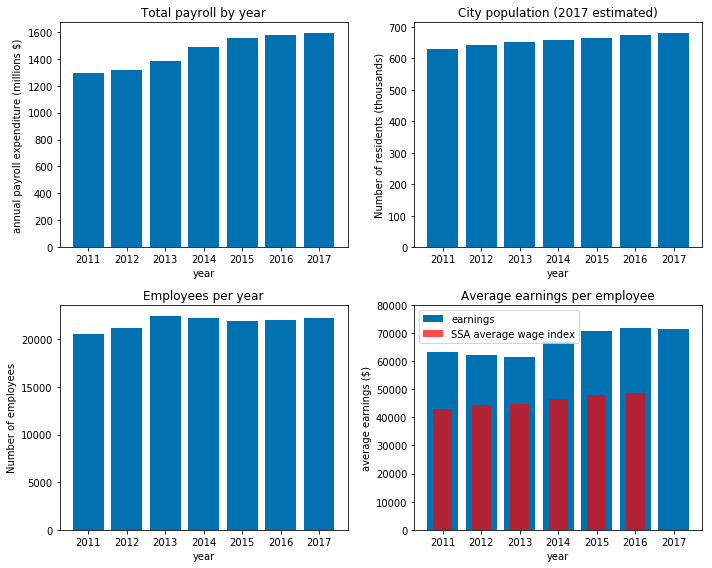

In [3]:
# total payroll by year
total_payroll = earnings.groupby(earnings['year'])[['total', 'name']]\
                        .agg({'total': np.sum, 'name': 'count'})\
                        .reset_index()\
                        .set_index('year')
total_payroll['epc'] = total_payroll['total'] / total_payroll['name'] # average earnings per capita
total_payroll = total_payroll.reset_index()

""" 
Average wage index (AWI) for the United States
Source: https://www.ssa.gov/oact/cola/awidevelop.html
"""
total_payroll['awi'] = pd.Series([42979.61, 44321.67, 44888.16, 46481.52, 48098.63, 48642.15]) # AWI, years 2011-2016

"""
City of Boston population estimates
https://www.census.gov/quickfacts/fact/table/bostoncitymassachusetts/PST045216
2017 data is extrapolated from 2011-2016 data
"""

year_actual, pop_actual = np.array([2011, 2012, 2013, 2014, 2015, 2016]), np.array([630195, 641911, 651090, 659180, 665984, 673184])
f = interpolate.interp1d(year_actual, pop_actual, fill_value='extrapolate')
population = np.append(pop_actual, f(2017))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

x = total_payroll['year']

# Total payroll by year
ax1.bar(x, total_payroll['total']/1000000)
ax1.set_xlabel('year')
ax1.set_ylabel('annual payroll expenditure (millions $)')
ax1.set_title('Total payroll by year')

# City population
ax2.bar(x, population/1000)
ax2.set_xlabel('year')
ax2.set_ylabel('Number of residents (thousands)')
ax2.set_title('City population (2017 estimated)')

# Employees per year
ax3.bar(x, total_payroll['name'])
ax3.set_xlabel('year')
ax3.set_ylabel('Number of employees')
ax3.set_title('Employees per year')

# Average earnings per employee
ax4.bar(x, total_payroll['epc'])
ax4.bar(x, total_payroll['awi'], width=0.5, alpha=0.7, color='r')
ax4.set_xlabel('year')
ax4.set_ylabel('average earnings ($)')
ax4.set_title('Average earnings per employee')
ax4.legend(['earnings', 'SSA average wage index'])
ax4.set_ylim(0, 80000)

plt.tight_layout()
plt.show()

The plots above show that the rate of payroll growth is slowing in the past few years. The number of employees has not grown since 2013 despite a growing population and the average earnings per employee are nearly stagnant since 2015.

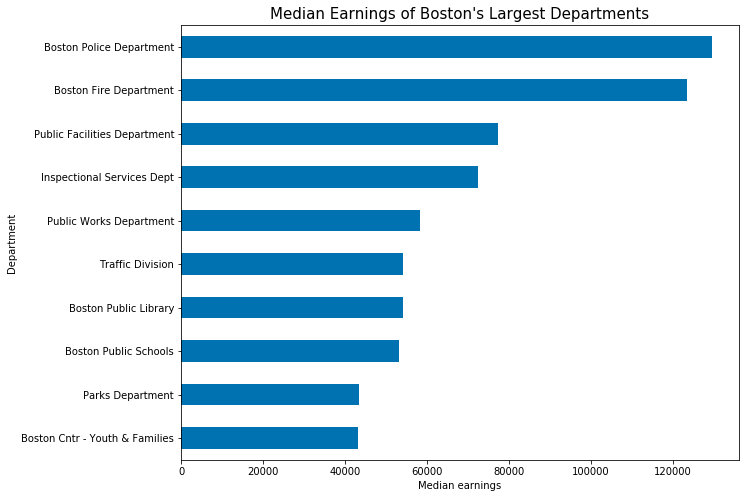

In [4]:
# Median earnings by department for 2017. Small departments are excluded for better statistics.

large_depts = pd.pivot_table(earnings[earnings.year==2017], values='total', aggfunc=[np.size, np.median], index='dept_clean')
large_depts = large_depts[large_depts[('size', 'total')] > 200] \
              .sort_values([('median', 'total')], ascending=False)[:15]

# for later use
large_depts_list = large_depts.index 

large_depts.columns = large_depts.columns.droplevel(1)
large_depts = large_depts['median']

fig = plt.figure(figsize=(10, 8))                 
large_depts.plot.barh().invert_yaxis()

_ = plt.title('Median Earnings of Boston\'s Largest Departments', fontsize=15)
_ = plt.ylabel('Department')
_ = plt.xlabel('Median earnings')
_ = plt.rc('ytick', labelsize=12)
_ = plt.rc('axes', labelsize=12)

plt.show()

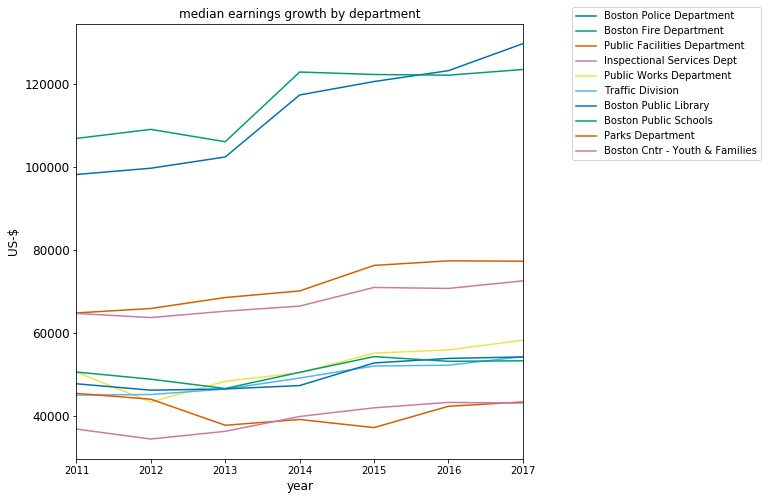

In [5]:
# plot earnings growth by department
ld = pd.pivot_table(earnings, index='year', columns='dept_clean', values=['total'], aggfunc=np.median)
ld.columns = ld.columns.droplevel()
ld = ld[large_depts_list].reset_index()   # list defined by size above

fig, ax = plt.subplots(figsize=(8,8))
ld.plot(x='year', y=large_depts_list, ax=ax)
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_title('median earnings growth by department')
ax.set_ylabel('US-$')
ax.set_xlabel('year')
# ax.set_yscale('log')
plt.show()

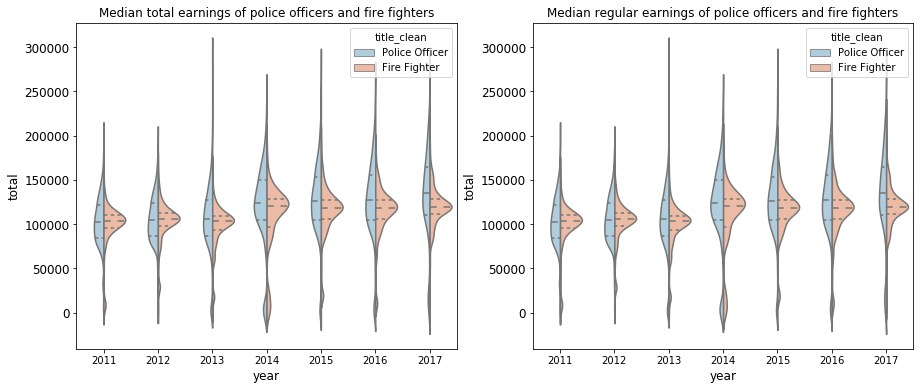

In [6]:
# fire fighters vs. police officers

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title('Median total earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax1,
              inner='quartile', palette='RdBu_r')
ax2.set_title('Median regular earnings of police officers and fire fighters')
sns.violinplot(x='year', y='total', hue='title_clean', data=ff, split=True, ax=ax2,
              inner='quartile', palette='RdBu_r')
plt.show()

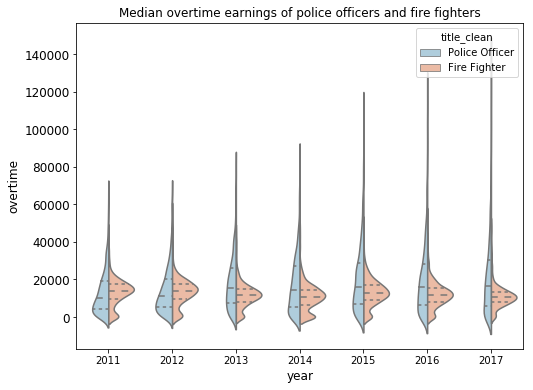

In [7]:
# fire fighters vs. police officers: Overtime

ff = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax= plt.subplots(figsize=(8, 6))
ax.set_title('Median overtime earnings of police officers and fire fighters')
sns.violinplot(x='year', y='overtime', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

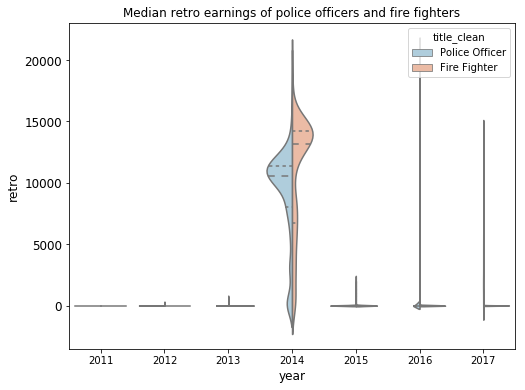

In [8]:
# What???

retro = earnings[(earnings['title_clean'] == 'Police Officer')\
                             | (earnings['title_clean'] == 'Fire Fighter')]

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Median retro earnings of police officers and fire fighters')
sns.violinplot(x='year', y='retro', hue='title_clean', data=ff, split=True, ax=ax,
              inner='quartile', palette='RdBu_r')
plt.show()

In [9]:
# retro earnings by year
retro_by_year = pd.pivot_table(earnings[earnings.retro != 0], columns='year', values='retro', index='dept_clean', aggfunc=[np.size, np.sum]).agg(np.sum)
print(retro_by_year)

      year
size  2011          30.00
      2012        2618.00
      2013       11948.00
      2014        4576.00
      2015          55.00
      2016         416.00
      2017        3256.00
sum   2011       84759.61
      2012      773973.86
      2013     8517434.02
      2014    47543988.05
      2015      110839.80
      2016    21247222.78
      2017     8864639.19
dtype: float64


In [10]:
# by dept
retro_by_dept = pd.pivot_table(earnings[(earnings.year == 2014)], values='retro', index='dept_clean', aggfunc=np.sum).sort_values(by='retro', ascending=False)
print(retro_by_dept[:10])

                                      retro
dept_clean                                 
Boston Police Department        25869366.20
Boston Fire Department          20414400.84
Boston Public Schools             773256.23
Boston Public Library             429864.57
Inspectional Services Dept         55438.08
Traffic Division                     874.04
Public Works Department              370.47
Auditing Department                  232.28
Dpt of Innovation & Technology       108.80
Public Facilities Department          76.54


In [11]:
# by title
retro_by_title = earnings[(earnings.year == 2014) \
                          & (earnings.dept_clean.isin(['Boston Police Department', \
                                                        'Boston Fire Department']))]\
                        .groupby('title_clean')\
                        ['retro']\
                        .agg(np.sum)\
                        .sort_values(ascending=False)
print(retro_by_title[:10])


title_clean
Police Officer         14937410.50
Fire Fighter           12972714.44
Police Sergeant         7027087.70
Fire Lieutenant         3442900.34
Police Lieutenant       2354503.79
Fire Captain            1307054.20
District Fire Chief     1098565.69
Police Captain           858703.64
Police Detective         368960.06
Dep Fire Chief           365344.38
Name: retro, dtype: float64


In [12]:
# by name 2016
retro_by_name = earnings.loc[(earnings.year == 2016) & (earnings.title == 'Police Detective')]\
                    [['name', 'regular', 'retro']]\
                    .sort_values(by='retro', ascending=False)
print(retro_by_name[:20])

                        name   regular      retro
110366         Brown,Gregory  97892.80  134476.33
126067           Ruiz,Melvin  99772.94  130420.43
123969        Painten,Paul A  92514.73  115642.68
123867    O'Sullivan,David M  98732.94  112780.19
122184         Mills,Vance C  93675.06  109967.56
128360    Tierney,Matthew M.   2862.18  107585.36
130272        Zingg,Robert M  97455.29  107368.53
112789     Cummings,Joshua O  96148.65  103432.55
117367            Herron,Tod  92514.73  102964.44
113908        Doogan,Kevin M  92514.73  102310.46
129534      Whalen,Richard L  72186.81  102255.55
119144         King,Joseph S  85387.59  101540.42
118580      Josey,Windell C.  92514.73  100296.36
115423     Fratalia,Robert A  96988.02   98878.64
108309    Acloque,Jean Moise  99361.13   98309.68
120483       MacIsaac,Paul A  92514.73   97629.64
109786        Blair,Steven F  92514.73   96211.51
110077  Boyle,Christopher R.  90180.85   96175.40
128315      Thompson,James M  92077.30   95827.00


In [13]:
greg = earnings.loc[earnings.name == 'Brown,Gregory']
greg

,Unnamed: 0,name,department,title,regular,retro,other,overtime,injured,detail,quinn,total,zip,year,dept_clean,title_clean
3953,3953,"Brown,Gregory",Boston Police Department,Police Detective,76091.03,0.00,12010.00,77234.02,0.0,0.0,0.0,165335.05,02301,2011,Boston Police Department,Police Detective
26466,26466,"Brown,Gregory",Boston Police Department,Police Detective,75651.04,0.00,11804.00,72755.78,0.0,8111.0,0.0,168321.82,02301,2012,Boston Police Department,Police Detective
43777,43777,"Brown,Gregory",Boston Police Department,Police Detective,75651.03,0.00,11804.00,86943.67,0.0,6126.0,0.0,180524.70,02301,2013,Boston Police Department,Police Detective
81594,81594,"Brown,Gregory",Boston Police Department,Police Detective,75651.03,0.00,11804.00,82928.54,0.0,11194.0,0.0,181577.57,02301,2014,Boston Police Department,Police Detective
88424,88424,"Brown,Gregory",Boston Police Department,Police Detective,77020.28,0.00,11754.00,98618.64,0.0,11040.0,0.0,198432.92,02301,2015,Boston Police Department,Police Detective
110366,110366,"Brown,Gregory",Boston Police Department,Police Detective,97892.80,134476.33,15752.49,87511.88,0.0,16192.0,0.0,351825.50,02301,2016,Boston Police Department,Police Detective
130902,130902,"Brown,Gregory",Boston Police Department,Police Detective,103987.91,5526.34,15752.48,122364.06,0.0,2024.0,0.0,249654.79,02301,2017,Boston Police Department,Police Detective


In [14]:
"""
Adjusted Gross Income (AGI) by zip code

Available for years 1998 through 2015
from:
https://www.irs.gov/statistics/soi-tax-stats-individual-income-tax-statistics-2015-zip-code-data-soi

data:
https://www.irs.gov/pub/irs-soi/15zpallagi.csv
data documentation:
https://www.irs.gov/pub/irs-soi/15zpdoc.doc

"""
agi = pd.read_csv('15zpallagi.csv', encoding = "ISO-8859-1", usecols=['STATE', 'zipcode', 'agi_stub', 'N1', 'NUMDEP', 'A00100', 'A00200', 'A02650'], dtype={'zipcode': object})
agi['sum'] = agi['N1'] *  agi['A00100']
agi = agi.groupby('zipcode').agg(np.sum).reset_index()

agi['agi'] = agi['sum'] / agi['N1']

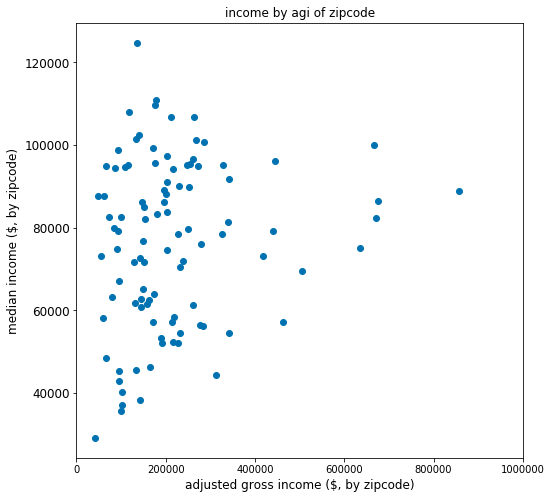

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
zipcode = earnings.groupby('zip')['total'].agg([np.size, np.median]).sort_values(by='size', ascending=False).reset_index()[:100]
zip_agi = pd.merge(zipcode, agi, left_on='zip', right_on='zipcode', how='left')
ax.scatter(zip_agi['agi'], zip_agi['median'])
ax.set_xlim(0, 1000000)
ax.set_xlabel('adjusted gross income ($, by zipcode)')
ax.set_ylabel('median income ($, by zipcode)')
ax.set_title('income by agi of zipcode')
# plt.xticks(rotation='vertical')
# ax.locator_params(nbins=25, axis='x')
plt.show()

## Residency Requirement
Boston city employees are required to live within city limits. The law is not strictly enforced and is confounded by state, federal and union regulations. 

https://www.boston.gov/departments/human-resources/residency-requirements-city-workers

https://www.bostonglobe.com/metro/2016/01/13/mayor-walsh-seeks-strengthen-boston-residency-requirement-with-caveat/ZyG8xmkOsu0dMHgITSUOKN/story.html

What does the distribution look like in 2017?

68 % of city employees live in Boston (2017).


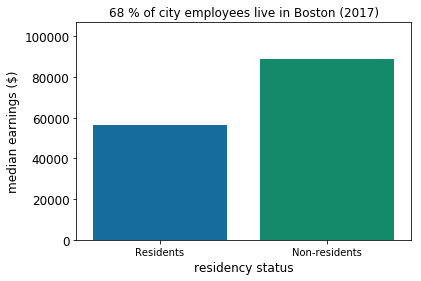

In [16]:
# Read in Boston zipcode list
boston_zips = pd.read_csv('boston-zipcodes.csv', names=['bzips'], header=None)
boston_zips = boston_zips.astype(str).apply(lambda x: '0' + x) # treat zipcodes as strings and add leading "0"

# define resident and non-resident employees
inzips = earnings.loc[(earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
outzips = earnings.loc[(~earnings.zip.isin(boston_zips.bzips) & (earnings.year == 2017))]
residents = inzips.shape[0] /(inzips.shape[0] + outzips.shape[0]) * 100
print(int(residents), '% of city employees live in Boston (2017).')

# income distribution
in_earnings = inzips['total'].agg(np.median)
out_earnings = outzips['total'].agg(np.median)
zip_df = pd.DataFrame({'residency status': ['Residents', 'Non-residents'], 'median earnings ($)': [in_earnings, out_earnings]}, index=[0, 1])

# plot
plt.title('%s %% of city employees live in Boston (2017)'%(int(residents)))
sns.barplot(x='residency status', y='median earnings ($)', data=zip_df)
plt.margins(0.2)
plt.show()